In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from communication.bluetooth import *
from leap_tracker import LeapTracker
from time import sleep
# from utils.Toolbox import *
import matplotlib.pyplot as plt
import numpy as np

In [3]:
leap_tracker = LeapTracker()
leap_tracker.connect('Desktop')

fsr32 = ESP32(device_name="MAR9", write_char_uuid="d162efba-143b-4535-9f2d-cf481f07428e", ble_uuid="e4de81ee-e12c-421f-98e7-060e0504f78c")
await fsr32.async_connect()

on_connection_event
Connect LeapMotion ...
Found device LP06817473783
on_tracking_mode_event
Found device: DC:54:75:D7:FA:E6: MAR9
Connected to: MAR9


In [4]:
force_log = []
position_log = []

In [5]:
for i in range(100):
    exist, right_tips_pos = leap_tracker.get_right_tips_pos()

    if exist:
        T_right_tips = []
        p_h = []
        for i in range(5):
            right_tip_pos = right_tips_pos[i]
            T_right_tip_pos = np.block([[np.identity(3), right_tip_pos.reshape(-1, 1) * 0.0014], [np.zeros([1, 3]), 1]])
            T_right_tips.append(T_right_tip_pos)
            p_h.append(T_right_tip_pos[0:3, 3])

        await fsr32.async_request_info()
        force_bytes = await fsr32.async_read_data()
        force_str = force_bytes.decode('utf-8')  # Converts bytearray to '149,9,255,55,5,'
        force = [int(f) for f in force_str.split(',') if f]  # Split and convert to integers
        print(force)
        force_log.append(force)
        position_log.append(p_h)

    # sleep(0.1)

[156, 9, 255, 57, 170]
[165, 9, 255, 56, 255]
[160, 10, 255, 58, 255]
[174, 10, 255, 55, 255]
[165, 10, 255, 58, 255]
[158, 9, 255, 56, 255]
[170, 10, 255, 55, 255]
[164, 9, 255, 57, 255]
[168, 10, 255, 55, 255]
[180, 11, 255, 58, 255]
[176, 11, 255, 58, 255]
[178, 12, 255, 56, 255]
[177, 10, 255, 58, 255]
[174, 10, 255, 57, 255]
[174, 9, 255, 58, 255]
[174, 10, 255, 55, 255]
[178, 10, 255, 57, 255]
[175, 11, 255, 58, 255]
[177, 10, 255, 55, 255]
[174, 11, 255, 57, 255]
[172, 11, 255, 55, 255]
[175, 10, 255, 57, 255]
[174, 10, 255, 56, 255]
[186, 10, 255, 56, 255]
[179, 10, 255, 57, 255]
[169, 11, 255, 58, 255]
[165, 10, 255, 59, 255]
[172, 9, 255, 56, 255]
[172, 10, 255, 57, 255]
[160, 9, 255, 56, 255]
[158, 9, 255, 55, 255]
[167, 11, 255, 58, 255]
[165, 10, 255, 56, 255]
[165, 10, 255, 58, 255]
[171, 10, 255, 56, 255]
[163, 10, 255, 56, 255]
[175, 11, 255, 66, 255]
[255, 157, 255, 141, 255]
[255, 138, 255, 128, 255]
[255, 138, 255, 129, 255]
[255, 144, 255, 131, 255]
[255, 158, 255, 

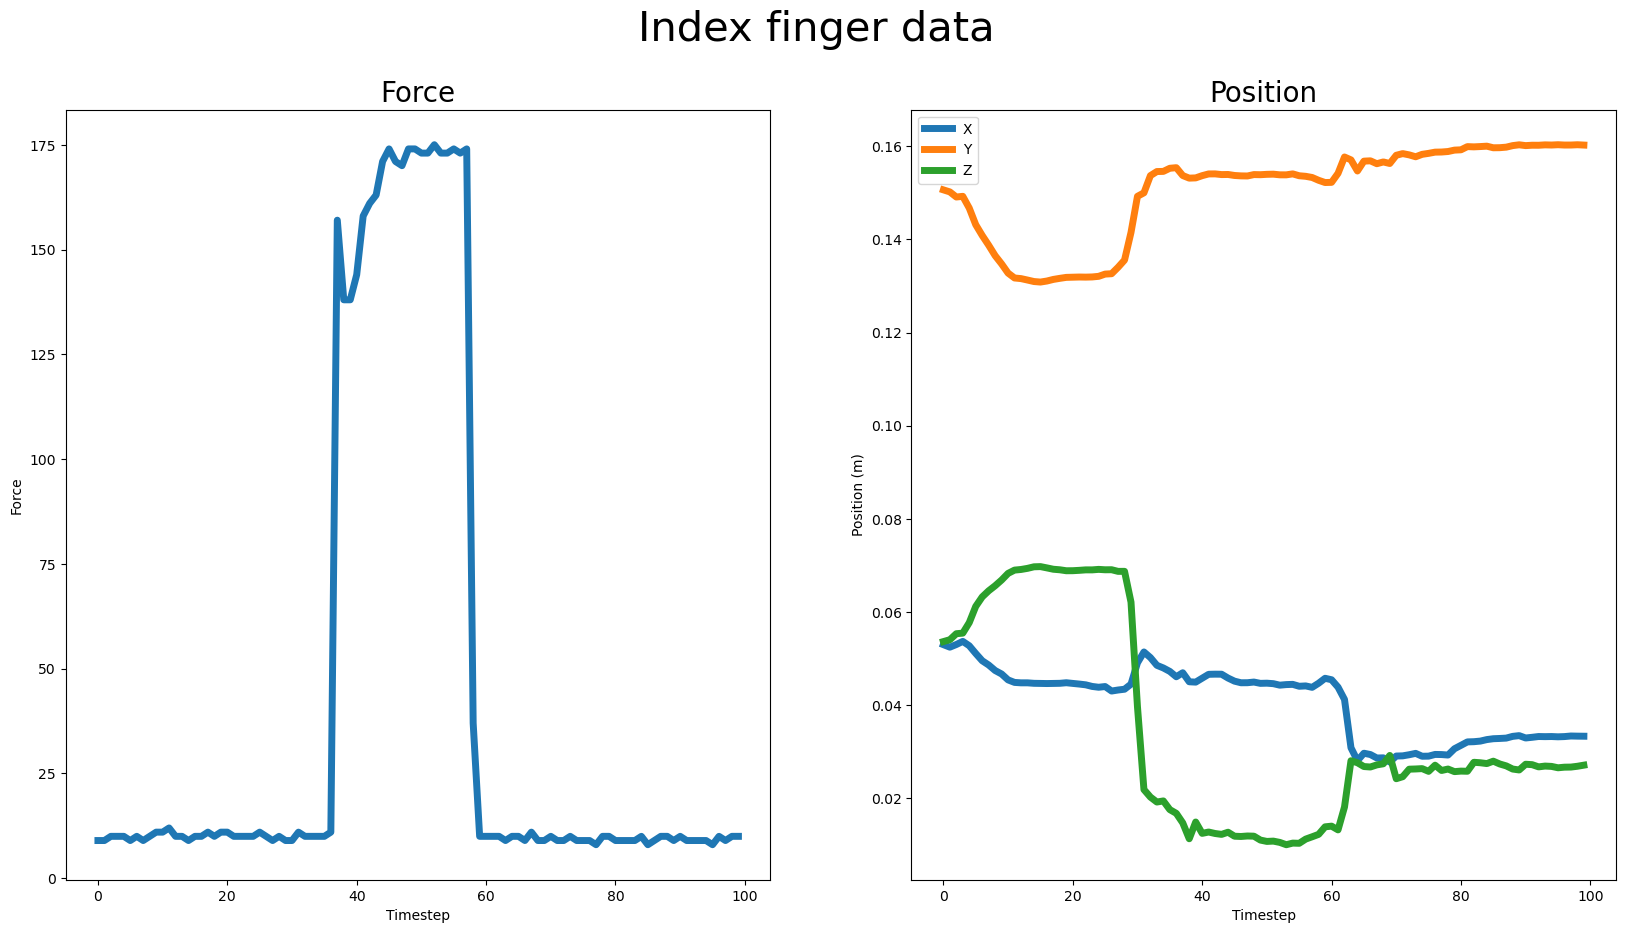

In [17]:
force_log = np.array(force_log)
position_log = np.array(position_log)



plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(force_log[:,1], linewidth=5)
plt.title("Force", fontsize=20)
plt.xlabel("Timestep")
plt.ylabel("Force")

plt.subplot(1, 2, 2)
plt.plot(position_log[:,1,0], label="X", linewidth=5)
plt.plot(position_log[:,1,1], label="Y", linewidth=5)
plt.plot(position_log[:,1,2], label="Z", linewidth=5)
plt.title("Position", fontsize=20)
plt.legend()
plt.ylabel("Position (m)")
plt.xlabel("Timestep")


plt.suptitle("Index finger data", fontsize=30)
plt.show()


In [14]:
with open('test001.txt', 'w') as f:
    f.write(str(force_log))
    f.write(str(position_log))

In [29]:
class SecondOrderFilter():
    def __init__(self, cutoff_freq, zeta, sampling_rate):
        self.cutoff_freq = cutoff_freq
        self.zeta = zeta
        self.sampling_rate = sampling_rate
        self.a = [0, 0]
        self.b = [0, 0, 0]
        self.x = [0, 0]
        self.y = [0, 0]
        self.calculate_coefficients()

    def calculate_coefficients(self):
        raise NotImplementedError
    
    def process(self, x):
        # y = b0 * x + b1 * x1 + b2 * x2 - a1 * y1 - a2 * y2
        y = self.b[0] * x + self.b[1] * self.x[0] + self.b[2] * self.x[1] - self.a[0] * self.y[0] - self.a[1] * self.y[1]

        self.x[1] = self.x[0]
        self.x[0] = x

        self.y[1] = self.y[0]
        self.y[0] = y

        return y

    def zero(self):
        self.x = [0, 0]
        self.y = [0, 0]

class SecondOrderLPF(SecondOrderFilter):
    def __init__(self, cutoff_freq, zeta, sampling_rate):
        super().__init__(cutoff_freq, zeta, sampling_rate)

    def calculate_coefficients(self):
        omega = 2 * np.pi * self.cutoff_freq / self.sampling_rate
        sin_omega = np.sin(omega)
        cos_omega = np.cos(omega)
        alpha = sin_omega / (2*self.zeta)

        b0_raw = (1 - cos_omega) / 2
        b1_raw = 1 - cos_omega
        b2_raw = (1 - cos_omega) / 2

        a0_raw = 1 + alpha
        a1_raw = - 2 * cos_omega
        a2_raw = 1 - alpha

        b0 = b0_raw / a0_raw
        b1 = b1_raw / a0_raw
        b2 = b2_raw / a0_raw
        a1 = a1_raw / a0_raw
        a2 = a2_raw / a0_raw

        self.a = [a1, a2]
        self.b = [b0, b1, b2]

class SecondOrderHPF(SecondOrderFilter):
    def __init__(self, cutoff_freq, zeta, sampling_rate):
        super().__init__(cutoff_freq, zeta, sampling_rate)

    def calculate_coefficients(self):
        omega = 2 * np.pi * self.cutoff_freq / self.sampling_rate
        sin_omega = np.sin(omega)
        cos_omega = np.cos(omega)
        alpha = sin_omega / (2*self.zeta)

        b0_raw = (1 + cos_omega) / 2
        b1_raw = - 1 - cos_omega
        b2_raw = (1 + cos_omega) / 2

        a0_raw = 1 + alpha
        a1_raw = - 2 * cos_omega
        a2_raw = 1 - alpha

        b0 = b0_raw / a0_raw
        b1 = b1_raw / a0_raw
        b2 = b2_raw / a0_raw
        a1 = a1_raw / a0_raw
        a2 = a2_raw / a0_raw

        self.a = [a1, a2]
        self.b = [b0, b1, b2]

class SecondOrderBPF(SecondOrderFilter):
    def __init__(self, center_freq, zeta, sampling_rate):
        super().__init__(center_freq, zeta, sampling_rate)
    
    def calculate_coefficients(self):
        # Calculate normalized angular frequency
        omega = 2 * np.pi * self.cutoff_freq / self.sampling_rate
        sin_omega = np.sin(omega)
        cos_omega = np.cos(omega)
        
        # For a bandpass filter, with Q = 1/(2*zeta),
        # alpha = sin(omega)/(2*Q) = sin(omega)*zeta
        alpha = sin_omega * self.zeta

        # Biquad bandpass coefficients (constant skirt gain)
        b0_raw = sin_omega / 2
        b1_raw = 0
        b2_raw = -sin_omega / 2
        a0_raw = 1 + alpha
        a1_raw = -2 * cos_omega
        a2_raw = 1 - alpha

        # Normalize coefficients
        b0 = b0_raw / a0_raw
        b1 = b1_raw / a0_raw
        b2 = b2_raw / a0_raw
        a1 = a1_raw / a0_raw
        a2 = a2_raw / a0_raw

        self.a = [a1, a2]
        self.b = [b0, b1, b2]

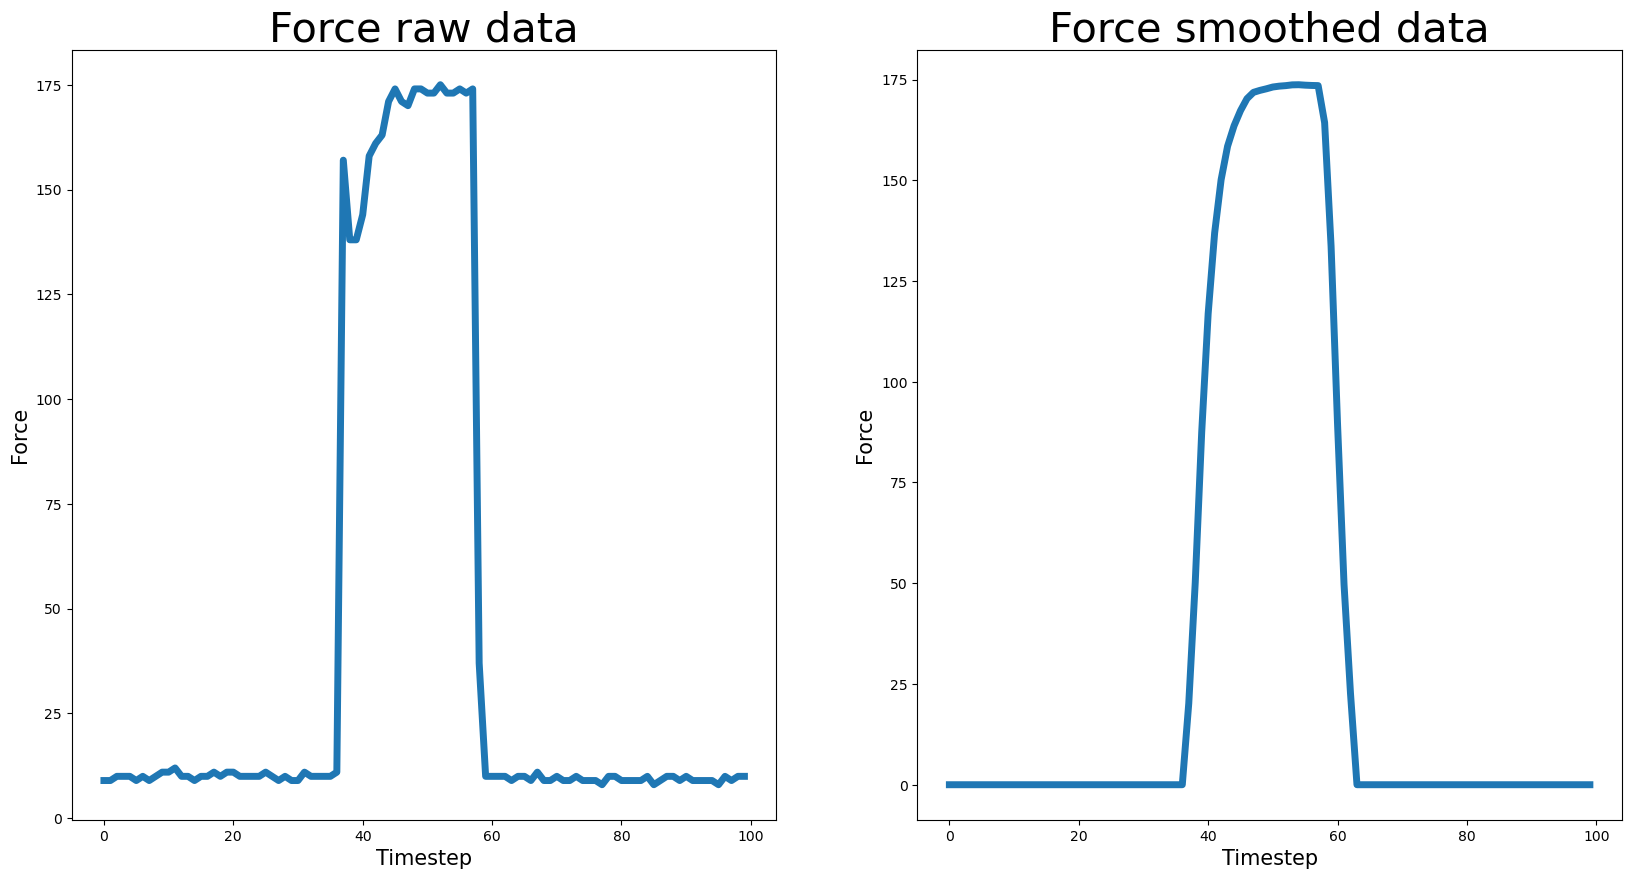

In [51]:
lpf = SecondOrderLPF(10, 0.707, 100)
force_filtered = np.array([lpf.process(x) for x in force_log[:,1]])
force_filtered[force_filtered < 20] = 0

plt.figure(figsize=(20, 10))

plt.subplot(1,2,1)
plt.plot(force_log[:,1], linewidth=5)
plt.title("Force raw data", fontsize=30)
plt.xlabel("Timestep", fontsize=15)
plt.ylabel("Force", fontsize=15)

plt.subplot(1,2,2)
plt.plot(force_filtered, linewidth=5)
plt.title("Force smoothed data", fontsize=30)
plt.xlabel("Timestep", fontsize=15)
plt.ylabel("Force", fontsize=15)
plt.show()

In [53]:
leap_tracker.disconnect()


Disconnect LeapMotion ...
